In [1]:
from single_cell_model import SingleCellCalciumModel
from fluorescence_encoder import FluorescenceEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
from scipy.integrate import odeint
from tqdm import tqdm_notebook, _tqdm_notebook, tnrange
import matplotlib.animation as anim
import pandas as pd

In [2]:
T = 15
dt = 0.001

In [3]:
class CellGridCalciumModel(SingleCellCalciumModel):
    def __init__(self, num):
        super().__init__()
        self.num = num
        self.gc = 500
        onex = np.ones(self.num)
        oney = np.ones(self.num)
        
        Dx = spdiags(np.array([onex,-2*onex,onex]),\
        np.array([-1,0,1]),self.num,self.num).toarray()
        
        Dx[0,0] = -1
        Dx[self.num-1,self.num-1] = -1 
        
        Ix = np.eye(self.num)
        Dy = spdiags(np.array([oney,-2*oney,oney]),\
        np.array([-1,0,1]),self.num,self.num).toarray()
        Dy[0,0] = -1; Dy[self.num-1,self.num-1] = -1
        
        Iy = np.eye(self.num)
        self.L = np.kron(Dx, Iy) + np.kron(Ix, Dy)
        
        self.time = np.linspace(0, T, int(T/dt))
    
    # Override
    def rhs(self, y, t):
        
        c, c_t, hh, ip, v, m, h, n = y[0:self.num*self.num], \
        y[self.num*self.num:2*self.num*self.num], \
        y[2*self.num*self.num:3*self.num*self.num], \
        y[3*self.num*self.num:4*self.num*self.num], \
        y[4*self.num*self.num:5*self.num*self.num], \
        y[5*self.num*self.num:6*self.num*self.num], \
        y[6*self.num*self.num:7*self.num*self.num], \
        y[7*self.num*self.num:8*self.num*self.num]
    
        dcdt = (self.i_ip3r(c, c_t, hh, ip) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta
        
        dctdt = (- self.i_pmca(c) - self.i_cal(v) + self.i_soc(c, c_t) - self.i_out(c))\
                 * self.delta

        dhhdt = (self.hh_inf(c, ip) - hh) / self.tau_hh(c, ip)

        dipdt = np.zeros(self.num*self.num)
    
        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
                  + 2*self.i_cal(v))/self.c_m\
               + self.gc * self.L@v
        
        dvdt[0:3*self.num] += self.stim(t)/self.c_m
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        
        deriv = np.array([dcdt, dctdt, \
                          dhhdt, dipdt, dvdt, dmdt, dhdt, dndt])
        
        dydt = np.reshape(deriv, 8*self.num*self.num)  
        
        return dydt
    
    # Override
    def stim(self, t):
        if (t >= 1 and t <= 1.1) \
        or (t >= 4 and t <= 4.1) \
        or (t >= 8 and t <= 8.1) \
        or (t >= 12 and t <= 12.1):
            return 0.5
        else:
            return 0
    
    # Override
    def step(self):
        self.hh0 = self.hh_inf(self.c0, self.ip0)
        
        y0 = np.array([self.c0*np.ones((self.num,self.num)), 
                       self.ct0*np.ones((self.num,self.num)), 
                       self.hh0*np.ones((self.num,self.num)), 
                       self.ip0*np.ones((self.num,self.num)), 
                       self.v0*np.ones((self.num,self.num)),
                       self.m0*np.ones((self.num,self.num)), 
                       self.h0*np.ones((self.num,self.num)), 
                       self.n0*np.ones((self.num,self.num))])

        y0 = np.reshape(y0, 8*self.num*self.num)
        
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol

In [4]:
if __name__ == '__main__':
    n_cel = 10
    model = CellGridCalciumModel(n_cel)
    sol = model.step()
    c = np.reshape(sol[:,0:n_cel*n_cel], (-1,n_cel,n_cel))

<IPython.core.display.Javascript object>


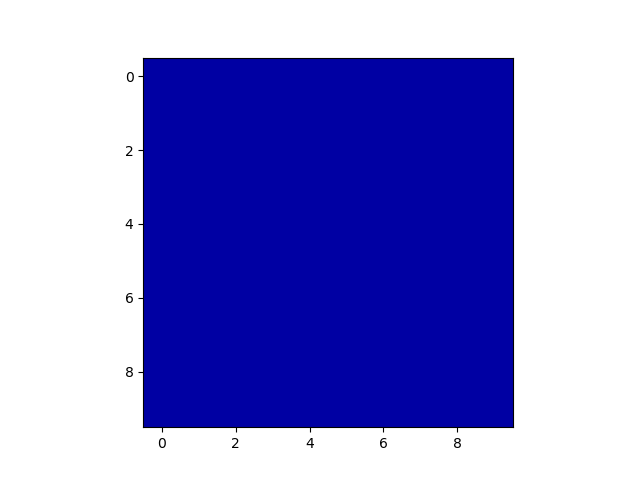

In [5]:
%matplotlib notebook
fig, ax = plt.subplots()
ims = []
for j in tnrange(np.int(T/(10*dt))):
    im = plt.imshow(c[10*j], cmap = 'jet', animated = True, vmin=0, vmax=1)
    ims.append([im])

ani = anim.ArtistAnimation(fig, ims, interval = 1, blit=False, repeat = True)

plt.show()

<IPython.core.display.Javascript object>


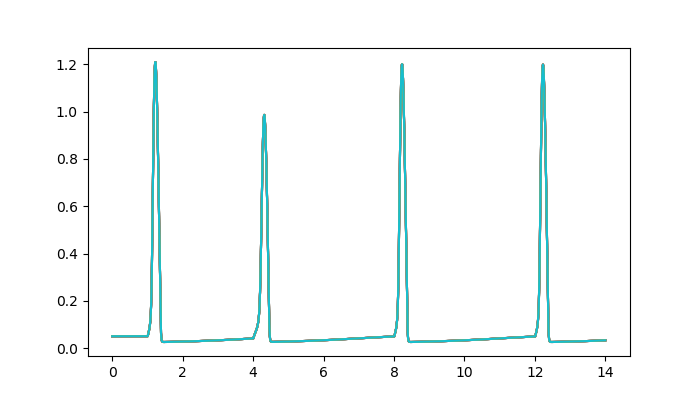

In [6]:
model.plot(c[:, 0])

In [28]:
df = pd.DataFrame(np.reshape(c,(15000,100)))
df.to_csv('c.csv', index='False')

In [6]:
df = pd.read_csv('c.csv', index_col=0)
c = np.reshape(df.values,(15000,10,10))

In [8]:
fluo = np.zeros((15000,10,10))

In [9]:
for i in range(2):
    for j in range(2):
        fluo[:,i,j] = FluorescenceEncoder(c[:,i,j]).step()

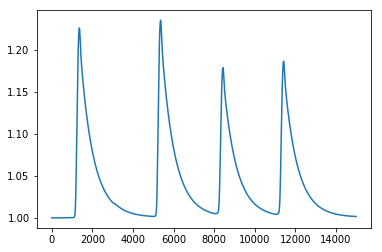

In [11]:
plt.plot(fluo[:,0,0])